Example extending the validphys API to utilize grids instead of FkTables to compute different quantities.

In this example the grids are all in the folder `pineappl_grids` set in the first cell of the notebook.

Since it is using validphys in the background the grids need to have exact the same name they would have if they were FKTables.

This notebooks monkeypatchs the following validphys functions:

```
validphys.results.results
validphys.results.results_central
validphys.theorycovariance.construction.results_central_bytheoryids
```

to utilize the pineappl grids directly instead of loading them as FKTables.

Note that any function in validphys that computes predictions without going through any of those three will try to use FkTables and will thus fail.

In [1]:
from pathlib import Path
from validphys.convolution import OP
from validphys.pineparser import EXT
import numpy as np
import pandas as pd
import pineappl
from dataclasses import dataclass
from lhapdf import setVerbosity
from collections import defaultdict
import functools
import tabulate

setVerbosity(0)

grid_path = Path("pineappl_grids")

# Since the _actual_ theory ID is (should?) be irrelevant, just put some number that you have already downloaded
# This will be used to organize the scale-varied result later
tid = 600

# 9 points
all_scales = [(1.0, 1.0), (1.0, 2.0), (2.0, 1.0), (1.0, 0.5), (0.5, 1.0), (0.5, 0.5), (2.0, 2.0), (2.0, 0.5), (0.5, 2.0)]
# Do just 3 for testing
all_scales = [(1.0, 1.0), (1.0, 2.0), (2.0, 1.0)]

In [2]:
class PineObject:

    def __init__(self, pine_path, factor=1.0):
        self._grid = pineappl.grid.Grid.read(pine_path)

        # Not all grids need normalization???
        # set it to true _for the time being_
        self._apply_bin = True

        self._factor = factor
        self._name = pine_path.name

    @functools.lru_cache
    def convolute(self, pdf):
        """Convolute the grid with a PDF, output as (nmembers, ndata, nscales)"""
        if not hasattr(pdf, "members"):
            pdf = pdf.load()
        ret = []
        bin_norm = self._grid.bin_normalizations().reshape(-1, 1)
        
        for i, member in enumerate(pdf.members):
            tmp = self._grid.convolute_with_one(2212, member.xfxQ2, member.alphasQ2, xi=all_scales).reshape(-1, len(all_scales))

            if self._apply_bin:
                tmp *= bin_norm
            ret.append(tmp)

        return np.array(ret)*self._factor

    def __str__(self):
        return f"PineObject({self._name})"

    def __repr__(self):
        return str(self)

class PineContainer:

    def __init__(self, pine_objects, dsname=None, operation=OP["NULL"]):
        self._name = dsname
        self._operation = operation
        self._pine_objects = pine_objects

    @functools.lru_cache
    def predictions(self, pdf):        
        operators = []
        for pine_operator in self._pine_objects:
            tmp = []
            for pine_bin in pine_operator:
                tmp.append(pine_bin.convolute(pdf))
            # tmp is shaped (ndata, scales)
            operators.append(np.concatenate(tmp, axis=1))

        # The operators is a list of (nmembers, ndata, nscales)

        # Loop over scales to get the result for all members for every scale
        return self._operation(*operators) # (nmembers, ndata, nscales)
        
    def __str__(self):
        return f"PineContainer({self._name})"

    def __repr__(self):
        return str(self)

In [3]:
# This cell contains the whole monkeypatching logic

import validphys.results
import validphys.theorycovariance.construction

@functools.lru_cache
def _get_pine_container(dataset):
    cd = dataset.commondata
    metadata = cd.metadata
    theory_meta = metadata.theory

    pinegrids = []
    for operator in theory_meta.FK_tables:
        tmp = []
        for i in operator:
            factor = theory_meta.conversion_factor
            if theory_meta.normalization is not None:
                factor *= theory_meta.normalization.get(i, 1.0)
            
            pine_path = grid_path / f"{i}.{EXT}"
            tmp.append(PineObject(pine_path, factor))
        pinegrids.append(tmp)

    operation = OP[theory_meta.operation]
    return PineContainer(pinegrids, dsname=dataset.name,  operation=operation)
    
def _pine_predictions(dataset, pdf, central_only=False):
    """Given a dataset and a PDF, produces predictions with pineappl
    The output shape is a list of DataFrames with the right shape for ThPredictions"""
    if central_only:
        pdf = pdf.load_t0()

    container = _get_pine_container(dataset)
    res_all_scales = container.predictions(pdf) # (n_members, n_data, n_scales)

    cuts = dataset.cuts.load()

    all_res = []
    for res in res_all_scales.T:
        all_res.append(pd.DataFrame(res).loc[cuts])

    return all_res

def new_results_central_by_theoryid(dataset, pdf, covariance_matrix, sqrt_covmat):
    dresult = validphys.results.DataResult(dataset, covariance_matrix, sqrt_covmat)
    ####### This is the part that changes wrt validphys
    ret = []
    theory_data_per_scale = _pine_predictions(dataset, pdf, central_only=True)
    for i, theory_data in enumerate(theory_data_per_scale):
        tmp = validphys.results.ThPredictionsResult(theory_data, pdf.stats_class, pdf=pdf, theoryid=tid+i)
        ret.append( (dresult, tmp) )
    #########
    return ret

def new_results(dataset, pdf, covariance_matrix, sqrt_covmat, central_only=False):
    dresult = validphys.results.DataResult(dataset, covariance_matrix, sqrt_covmat)
    ####### This is the part that changes wrt validphys
    theory_data = _pine_predictions(dataset, pdf, central_only=central_only)[0]
    theory_results = validphys.results.ThPredictionsResult(theory_data, pdf.stats_class, pdf=pdf)
    #########
    return (dresult, theory_results)

def new_results_central(dataset, pdf, covariance_matrix, sqrt_covmat, central_only=False):
    return new_results(dataset, pdf, covariance_matrix, sqrt_covmat, central_only=True)

validphys.results.results = new_results
validphys.results.results_central = new_results_central
validphys.theorycovariance.construction.results_central_bytheoryids = new_results_central_by_theoryid

# Make sure that from_convolution is never accessed
def raise_me(pdf, dataset, **kwargs):
    raise ValueError(".from_convolution is being used, please report this error!")

validphys.results.ThPredictionsResult.from_convolution = raise_me

The cell below is just a test that the above worked as expected.
In principle _any_ function using `results` to compute predictions would work.

The PDF uncertainties are much slower than validphys, grids need to compute many pairs of x/q.

Note: and _any_ function not using `results` should be changed to use it.

In [4]:
from validphys.api import API

pdf_name = "NNPDF40_nnlo_as_01180"
dname = "LHCB_WPWM_8TEV_MUON_Y"
kwargs = {"dataset_input": {"dataset": dname}, "theoryid" : tid, "use_cuts":"internal", "pdf": pdf_name}
theory_opt = {"point_prescription": "3 point", "theoryids": {"from_": "scale_variation_theories"}, "use_theorycovmat": True}

base_chi2 = API.abs_chi2_data(**kwargs)
print(f"Exp chi2: {base_chi2.central_result / base_chi2.ndata:.4}")

th_chi2 = API.abs_chi2_data_thcovmat(**kwargs, **theory_opt)
print(f"Exp+th chi2: {th_chi2.central_result / th_chi2.ndata:.4}")

full_chi2 = API.abs_chi2_data_thcovmat(**kwargs, **theory_opt, use_pdferr=True)
print(f"Exp+th+pdf chi2: {full_chi2.central_result / full_chi2.ndata:.4}")

Exp chi2: 0.5382
Exp+th chi2: 0.5037
Exp+th+pdf chi2: 0.425


/Users/jumax9/Academic_Workspace/NNPDF/src/nnpdf/validphys2/src/validphys/utils.py:193: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for same_vals, table in gb:


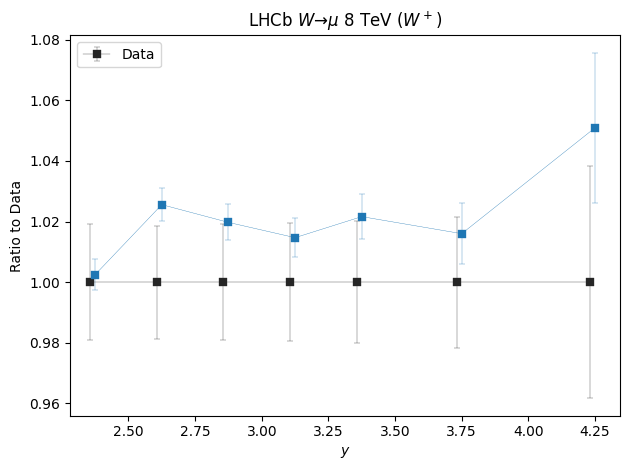

In [5]:
# Plot a theory-data comparison
from matplotlib import pyplot as plt
%matplotlib inline
figs = API.plot_fancy(**kwargs, normalize_to="data")
figs[0]

The cell below creates a `.pkl` format with all results with the following structure:

```
    exp_data: central experimental data
    exp_uncert: experimental uncertainties (+- 1sigma)
    predictions: theoretical predictions for the central scale
    pdf_uncert: pdf uncertainties
    theory_uncert: scale uncertainties
```

so that it can be reused in other functions.

In [6]:
def create_data_pickle(dname, pdf, theoryid, force=False, output_folder=Path(".")):
    data_path = Path(output_folder) / f"results_{dname}_{theoryid}_{pdf}.pkl"
     
    if data_path.exists() and not force:
        print(f"Skipping {dname} ({pdf}) since {data_path} already exists. If you want to overwrite it use `force=True`")
        return
        
    print(f"Computing predictions for {dname} with {pdf} (tid={theoryid})")
    generic = {
        "dataset_input": {"dataset": dname},
        "theoryid": theoryid,
        "pdf": pdf,
        "use_cuts": "internal",
    }

    # These two functions are using the monkey patching from before
    # so you better make sure they are being used in the same notebook!
    # otherwise you will be getting FKTable results and not grids!!!!!!1111

    res_data, res_theory = API.results(**generic)
    theory_covmat = API.theory_covmat_dataset(
        **generic,
        point_prescription="9 point",
        theoryids={"from_": "scale_variation_theories"},
        use_theorycovmat=True,
    )
    ret = {
        "exp_data": res_data.central_value,
        "predictions": res_theory.central_value,
        "exp_uncert": res_data.std_error,
        "pdf_uncert": res_theory.std_error,
        "theory_uncert": np.sqrt(np.diag(theory_covmat)),
    }
    ds = API.dataset(**generic)
    # Read the cuts 
    cuts = ds.cuts.load()+1 # kinematics start at 1
    kin_df = ds.commondata.metadata.load_kinematics().loc[cuts]
    results_df = pd.DataFrame(ret, index=kin_df.index)

    results_df.to_pickle(data_path)
    print(f"Predictions for {dname} written to {data_path} ({pdf=})")

#Example:
all_datasets = ["H1_2JET_319GEV_290PB-1_DIF_PTQ2"]
if True:
    for pdf in ["NNPDF40_nnlo_as_01180", "PDF4LHC21_mc"]:
        for dataset in all_datasets:
            create_data_pickle(dataset, pdf, 600, force=True, output_folder=Path("/tmp"))

Computing predictions for H1_2JET_319GEV_290PB-1_DIF_PTQ2 with NNPDF40_nnlo_as_01180 (tid=600)
Predictions for H1_2JET_319GEV_290PB-1_DIF_PTQ2 written to /tmp/results_H1_2JET_319GEV_290PB-1_DIF_PTQ2_600_NNPDF40_nnlo_as_01180.pkl (pdf='NNPDF40_nnlo_as_01180')
Computing predictions for H1_2JET_319GEV_290PB-1_DIF_PTQ2 with PDF4LHC21_mc (tid=600)
Predictions for H1_2JET_319GEV_290PB-1_DIF_PTQ2 written to /tmp/results_H1_2JET_319GEV_290PB-1_DIF_PTQ2_600_PDF4LHC21_mc.pkl (pdf='PDF4LHC21_mc')
